<a href="https://colab.research.google.com/github/michaldabrowski98/MalariaCNN/blob/master/malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPool2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import RootMeanSquaredError
from matplotlib import pyplot as plt

In [8]:
dataset, dataset_info = tfds.load(
    'malaria',
    with_info=True,
    as_supervised=True,
    shuffle_files=True,
    split=['train']
    )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteT4LOWS/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [9]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [10]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO)
print(
    list(train_dataset.take(1).as_numpy_iterator()),
    list(val_dataset.take(1).as_numpy_iterator()),
    list(test_dataset.take(1).as_numpy_iterator())
    )

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 0)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

# Data Visualization

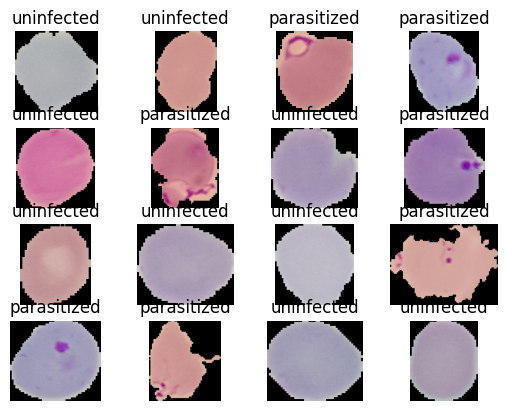

In [11]:
for i, (image, label) in enumerate(train_dataset.take(16)):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image)
    plt.title(dataset_info.features['label'].int2str(label))
    plt.axis('off')

# Data processing

In [12]:
IM_SIZE = 224
def resize_rescale(image, label):
    return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [13]:
train_dataset = train_dataset.map(resize_rescale)
val_dataset = val_dataset.map(resize_rescale)
test_dataset = test_dataset.map(resize_rescale)

In [14]:
for image,label in train_dataset.take(1):
    print(image,label)

tf.Tensor(
[[[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 ...

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]], shape=(224, 224, 3), dtype=float32) tf.Tensor(1, shape=(), dtype=int64)


In [15]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [16]:
val_dataset = val_dataset.shuffle(buffer_size=8, reshuffle_each_iteration=True).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [17]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),
    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation = 'relu'),
    BatchNormalization(),
    MaxPool2D(pool_size = 2, strides=2),

    Flatten(),

    Dense(100, activation = "relu"),
    BatchNormalization(),
    Dense(10, activation = "relu"),
    BatchNormalization(),
    Dense(1, activation = "sigmoid"), # ponieważ mogą być dwa wyniki, zainfekowana i niezainfekowana
])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [18]:
y_true = [0,1,0,0]
y_pred = [0.6,0.51,0.94,1]
bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=4.9340706>

In [19]:
lenet_model.compile(optimizer = Adam(learning_rate=0.01),
              loss = BinaryCrossentropy(),
              metrics = 'accuracy')

In [20]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs = 100, verbose=1)

Epoch 1/100
689/689 [==============================] - 59s 66ms/step - loss: 0.3623 - accuracy: 0.8426 - val_loss: 0.3866 - val_accuracy: 0.8766
Epoch 2/100
689/689 [==============================] - 54s 79ms/step - loss: 0.2149 - accuracy: 0.9270 - val_loss: 0.5007 - val_accuracy: 0.8784
Epoch 3/100
689/689 [==============================] - 48s 70ms/step - loss: 0.1739 - accuracy: 0.9420 - val_loss: 0.2496 - val_accuracy: 0.9365
Epoch 4/100
689/689 [==============================] - 50s 72ms/step - loss: 0.1586 - accuracy: 0.9476 - val_loss: 0.2690 - val_accuracy: 0.9220
Epoch 5/100
689/689 [==============================] - 54s 78ms/step - loss: 0.1567 - accuracy: 0.9477 - val_loss: 0.1519 - val_accuracy: 0.9535
Epoch 6/100
689/689 [==============================] - 46s 66ms/step - loss: 0.1374 - accuracy: 0.9555 - val_loss: 0.3939 - val_accuracy: 0.9303
Epoch 7/100
689/689 [==============================] - 49s 70ms/step - loss: 0.1305 - accuracy: 0.9557 - val_loss: 0.1644 - val_ac

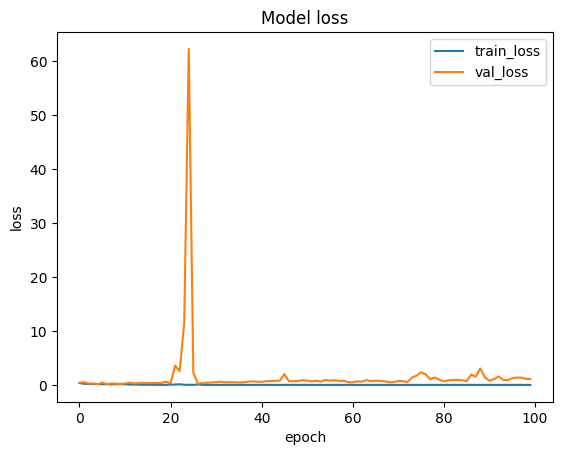

In [23]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
# print(history)

In [1]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])

NameError: ignored

# Model Evaluation and Testing

In [26]:
lenet_model.evaluate(test_dataset)

InvalidArgumentError: ignored